## Importowanie bibliotek

In [33]:
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor

In [3]:
model = SentenceTransformer('bert-base-cased')

No sentence-transformers model found with name /Users/kamil/.cache/torch/sentence_transformers/bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/kamil/.cache/torch/sentence_transformers/bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification m

## Ladowanie ocen zartow

In [18]:
ratings = pd.DataFrame()

for i in range(1,3):
    ratings_data = pd.read_excel(f'ratings/jester-data-{i}.xls', header=None)
    ratings_data = ratings_data.iloc[:, 1:].replace(99, float('nan'))
    ratings = pd.concat([ratings_data, ratings], ignore_index=True)

ratings

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,NaN,8.11,NaN,NaN,-2.28,-4.22,5.49,-2.62,NaN,-2.28,...,NaN,NaN,NaN,NaN,NaN,-5.92,NaN,NaN,NaN,NaN
1,-4.37,-3.88,0.73,-3.20,-6.41,1.17,7.82,-4.76,-6.41,0.73,...,5.73,-6.70,1.99,2.62,-0.49,3.45,3.20,-0.53,-0.53,-2.96
2,NaN,NaN,NaN,NaN,0.73,NaN,5.53,3.25,NaN,NaN,...,NaN,NaN,NaN,NaN,3.16,NaN,NaN,NaN,NaN,NaN
3,0.34,-6.55,2.86,NaN,-3.64,1.12,5.34,2.33,NaN,2.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,9.13,NaN,-9.32,-2.04,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48478,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,-8.74,7.23,...,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
48479,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,-8.11,4.90,...,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
48480,NaN,NaN,NaN,NaN,-7.77,NaN,6.70,-6.75,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48481,NaN,NaN,NaN,NaN,-9.71,NaN,4.56,-8.30,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
ratings = ratings.mean()

### teraz mamy wszystkie zarty i sredni poziom ich smiesznosci. Nr wiersza to ID zartu.

In [21]:
ratings

1      0.899789
2      0.158347
3      0.193208
4     -1.412918
5      0.263428
         ...   
96     1.484094
97     1.621445
98     0.914229
99     0.026375
100    1.116920
Length: 100, dtype: float64

## Zaladowanie tekstu zartow z pliku jokes

In [24]:
jokes = []

for i in range(1, 101):
    file_name = f'jokes/init{i}.html'
    with open(file_name, 'r') as file:
        joke_html = file.read()
        soup = BeautifulSoup(joke_html, 'html.parser')
        joke_text = soup.find('font', size='+1').text.strip()
        jokes.append(joke_text)


In [25]:
jokes[:2]

['A man visits the doctor. The doctor says "I have bad news for you.You have\ncancer and Alzheimer\'s disease". \nThe man replies "Well,thank God I don\'t have cancer!"',
 'This couple had an excellent relationship going until one day he came home\nfrom work to find his girlfriend packing. He asked her why she was leaving him\nand she told him that she had heard awful things about him. \n\n"What could they possibly have said to make you move out?" \n\n"They told me that you were a pedophile." \n\nHe replied, "That\'s an awfully big word for a ten year old."']

## Zamiana wartosci tekstowych zartu na wektor

In [26]:
model = SentenceTransformer('bert-base-cased')
embeddings = model.encode(jokes)

No sentence-transformers model found with name /Users/kamil/.cache/torch/sentence_transformers/bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/kamil/.cache/torch/sentence_transformers/bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification m

In [27]:
embeddings[:2]
# wartosci poszczegolnych pol w wektorze dla pierwszych dwoch zartow

array([[ 0.22689971,  0.08085272,  0.19379225, ...,  0.34821928,
         0.16816384,  0.22305518],
       [ 0.08381995,  0.15879399, -0.1869313 , ...,  0.24138366,
        -0.09729522, -0.13394892]], dtype=float32)

## Znormalizowanie danych zawartych w wektorze

In [31]:
scaler = StandardScaler()
normalized_embeddings = scaler.fit_transform(embeddings)
normalized_embeddings[:2]

array([[ 0.5769681 ,  0.5576384 ,  1.4792492 , ...,  0.78503287,
         0.9763304 ,  2.0398967 ],
       [-0.45947206,  1.1145141 , -1.4929714 , ..., -0.11595788,
        -0.9187749 , -1.0661879 ]], dtype=float32)

## Podzial danych na zbior testowy i walidacyjny

In [35]:
train_X, val_X, train_y, val_y = train_test_split(
    embeddings,
    ratings,
    test_size=0.2,
    random_state=3)

#### Istotne jest, by zacząć eksperymenty od możliwie jak najbardziej surowej sieci neuronowej.
Jeśli korzystasz z Pythona i pakietu sklearn, konkretnie klasy sklearn.neural network.MLPRegressor,
upewnij się, że przekazujesz następujące wartości hiperparametrów:
 • solver = ’sgd’
• alpha = 0.0
 • learning rate = ’constant’

The parameters in the `MLPRegressor` function define the configuration of a Multi-Layer Perceptron (MLP) regression model. Here's a description of each parameter:

1. `solver`: The solver parameter specifies the optimization algorithm used for weight optimization in the MLP model. In this case, `'sgd'` is used, which stands for Stochastic Gradient Descent. It updates the weights based on a small subset of the training data (mini-batches) at each iteration.

2. `alpha`: The alpha parameter controls the regularization strength in the MLP model. A value of `0.0` indicates no regularization is applied.

3. `learning_rate`: The learning_rate parameter determines the strategy for updating the learning rate during training. In this case, `'constant'` is used, which means the learning rate remains constant throughout the training process.

4. `learning_rate_init`: The learning_rate_init parameter sets the initial learning rate of the MLP model. Its value is determined by the `learning_rate_param` variable.

5. `hidden_layer_sizes`: The hidden_layer_sizes parameter specifies the architecture of the MLP model by defining the number of neurons in each hidden layer. It takes a tuple or a list of integers where each integer represents the number of neurons in a particular hidden layer. For example, `hidden_sizes` contains the values for the number of neurons in each hidden layer.

6. `random_state`: The random_state parameter is used to set the random seed for reproducibility. It ensures that the random initialization of the weights and biases in the MLP model is the same each time the code is run with the same seed value. In this case, `0` is used as the random seed.


The `mlp.loss_curve_` attribute in scikit-learn's MLP (Multi-Layer Perceptron) models stores the training loss values during the training process. It provides a record of the loss (error) value at each training iteration or epoch.

During the training of an MLP model, the loss function is minimized through an optimization process. The loss curve is a graphical representation of the loss value as it changes over the course of training. It helps visualize how the model's performance improves or converges over time.

The mlp.loss_curve_ attribute is a 1D array or list that stores the loss values at each epoch or iteration of training. You can use this attribute to analyze and plot the loss curve to gain insights into the model's training progress and convergence.



In [38]:
class LossType(Enum):
    TRAIN =1,
    VALIDATION = 2,
    LOSSCURVE=3

In [51]:
def run(learning_rate_param=0.001, learning_rate ='constant' ,hidden_sizes=(100,), loss_type=LossType.TRAIN,epochs = 1000) -> list:

    mlp = MLPRegressor(solver='sgd',
                       alpha=0.0,
                       learning_rate=learning_rate,
                       learning_rate_init=learning_rate_param,
                       hidden_layer_sizes=hidden_sizes,
                       random_state=0
                       )
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        mlp.partial_fit(train_X, train_y)

        pred_train_y = mlp.predict(train_X)
        train_loss.append(mean_squared_error(train_y, pred_train_y))

        pred_val_y = mlp.predict(val_X)
        val_loss.append(mean_squared_error(val_y, pred_val_y))

    loss_curve = mlp.loss_curve_

    if loss_type == LossType.TRAIN:
        return train_loss
    elif loss_type == LossType.VALIDATION:
        return val_loss
    elif loss_type == LossType.LOSSCURVE:
        return loss_curve
    else:
        raise ValueError(f"Invalid loss_type: {loss_type}. Use 'train' or 'val'.")

2. Przetestuj działanie podstawowego modelu MLP o domyślnej konfiguracji hiperparametrów, ucząc go na danych ze zbioru Jester. Prześledź zachowanie modelu w czasie, wizualizując wartość funkcji kosztu w funkcji liczby epok, zwracając uwagę na wartości dla zbioru uczącego i zbioru walidacyjnego. (20 punktów)

Testowanie podstawowego modelu. Badanie  wplywu epok na wyniki testow.

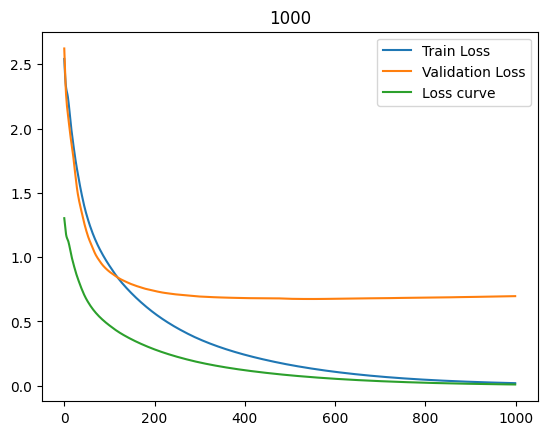

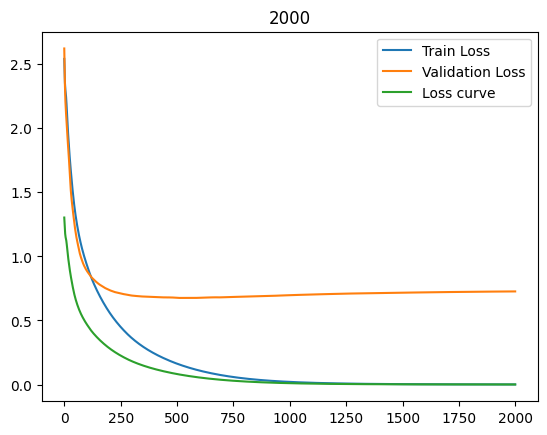

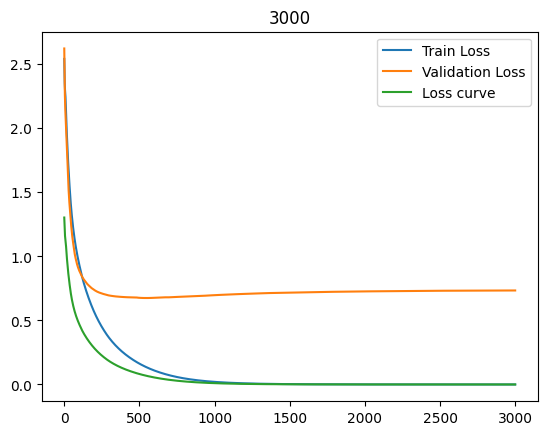

In [48]:
for epochs in range(1000,4000,1000):
    loss_train = run(loss_type=LossType.TRAIN,epochs=epochs)
    loss_val = run(loss_type=LossType.VALIDATION,epochs=epochs)
    loss_curve = run(loss_type=LossType.LOSSCURVE,epochs=epochs)
    plt.title(epochs)
    plt.plot(range(len(loss_train)), loss_train, label=f'Train Loss')
    plt.plot(range(len(loss_val)), loss_val, label=f'Validation Loss')
    plt.plot(range(len(loss_curve)), loss_curve, label=f'Loss curve')
    plt.legend()
    plt.show()

3. Zbadaj wpływ tempa uczenia (learning rate) na osiągane wyniki: powtórz uczenie dla 3 róż- nych wartości parametru. Dobierz odpowiednią długość procesu uczenia (liczbę epok) jeśli to konieczne. Przedstaw wyniki na wykresach jak w zadaniu poprzednim. Co dzieje się, gdy tempo uczenia jest zbyt niskie? Co, gdy zbyt wysokie? (30 punktów)

In [73]:
def learning_rate_testing(LossType):
    learning_rate_params = [1.,0.1,0.01,0.001]
    learning_rates = ['constant','adaptive','invscaling']


    for lrp in learning_rate_params:
        for lr in learning_rates:
            train_loss =  run(learning_rate_param=lrp, learning_rate=lr,loss_type=LossType)
            plt.plot(range(len(train_loss)), train_loss, label=f'rate_init={lrp} rate \'{lr}\'')
        plt.title(LossType.__str__())
        plt.ylim(0, 3)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


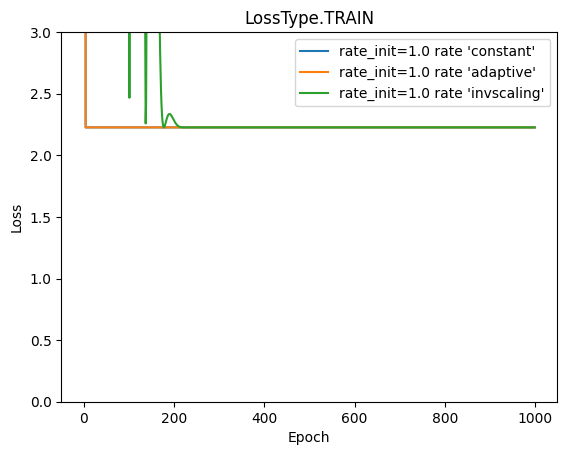

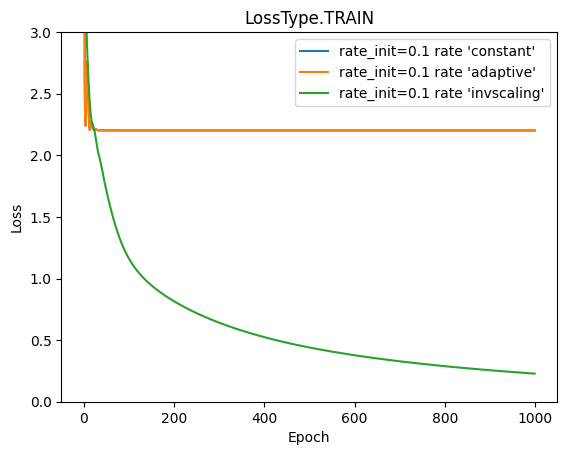

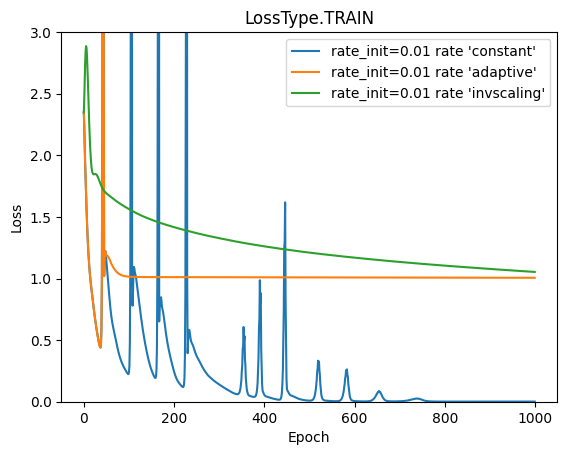

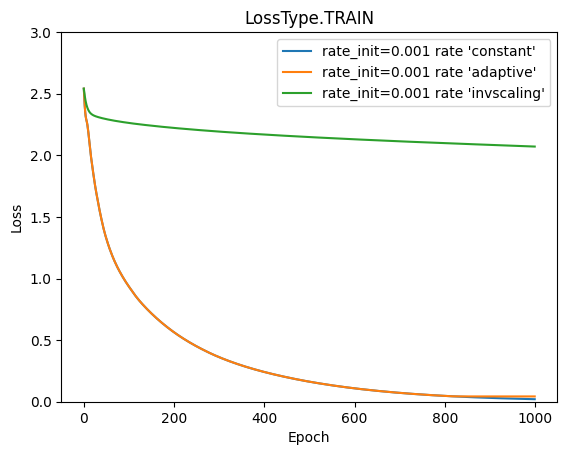

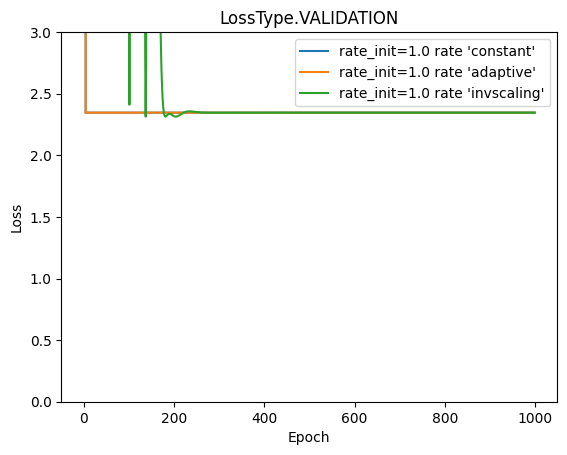

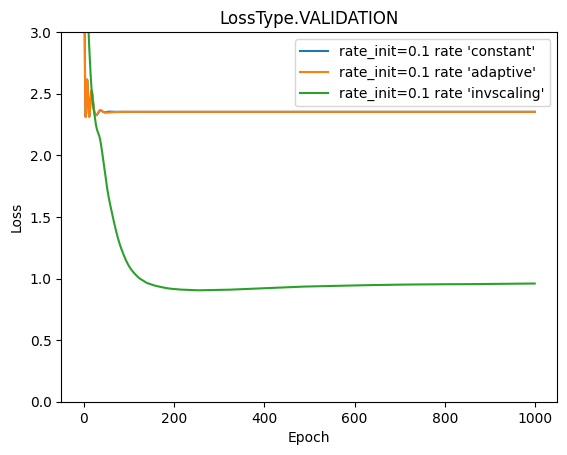

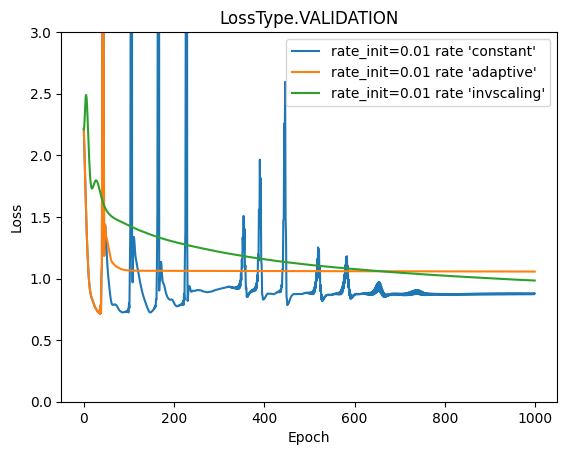

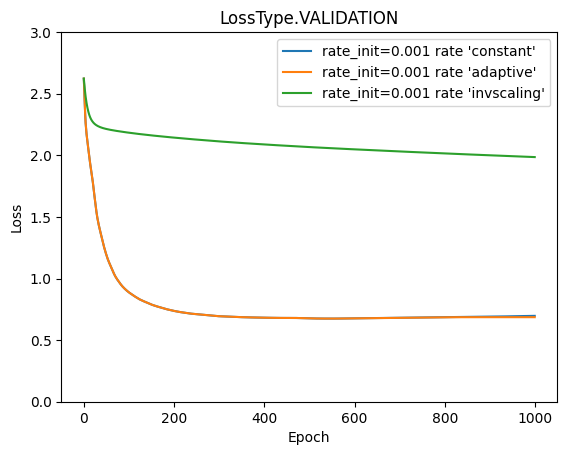

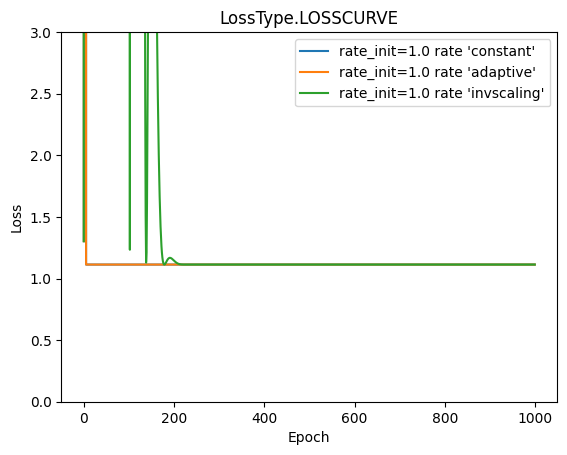

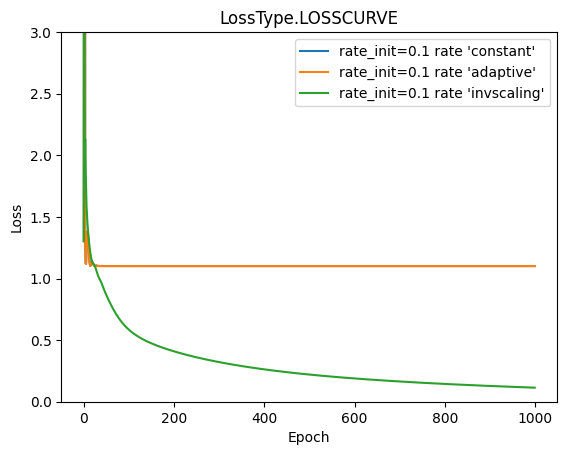

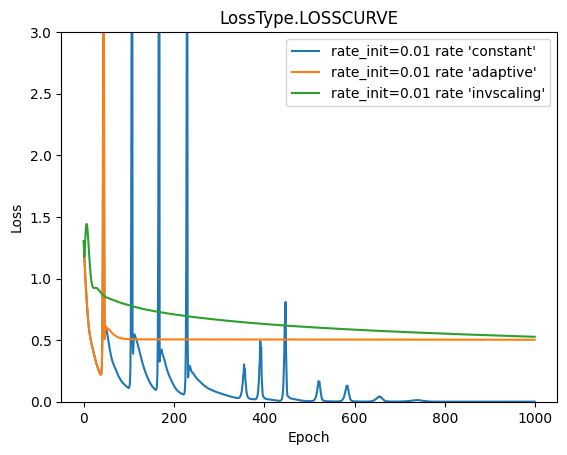

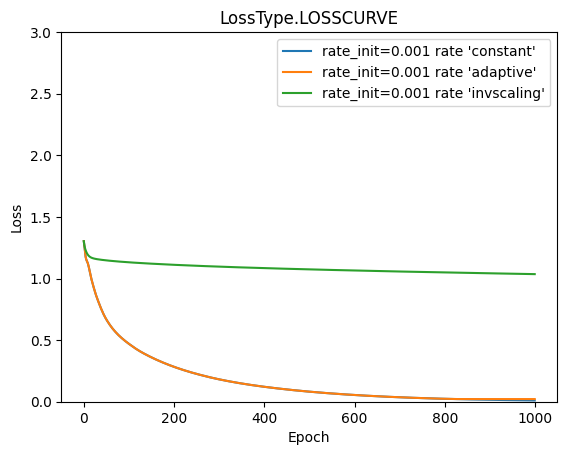

In [74]:
loss_types = [LossType.TRAIN,LossType.VALIDATION,LossType.LOSSCURVE]
for loss_type in loss_types:
    learning_rate_testing(loss_type)

4. Zbadaj wpływ rozmiaru modelu MLP na jakość działania:
wykonaj co najmniej 3 eksperymenty dla modeli różniących się liczbą neuronów. Kiedy model przestaje dobrze dopasowywać się do danych? Kiedy zaczyna zanadto dopasowywać się do zbioru uczącego? (30 punktów)

In [83]:
def hidden_layer_sizes_testing():
    hidden_layer_sizes = [(20,), (100,), (500,), (1000,)]
    loss_types = [LossType.TRAIN,LossType.VALIDATION,LossType.LOSSCURVE]
    for hls in hidden_layer_sizes:
        for lt in loss_types:
            train_loss =  run(hidden_sizes=hls,loss_type=lt)
            plt.plot(range(len(train_loss)), train_loss, label=f'type \'{str(lt)}\'')
        plt.title( f'hidden layer size={hls}')
        plt.ylim(0, 3)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()



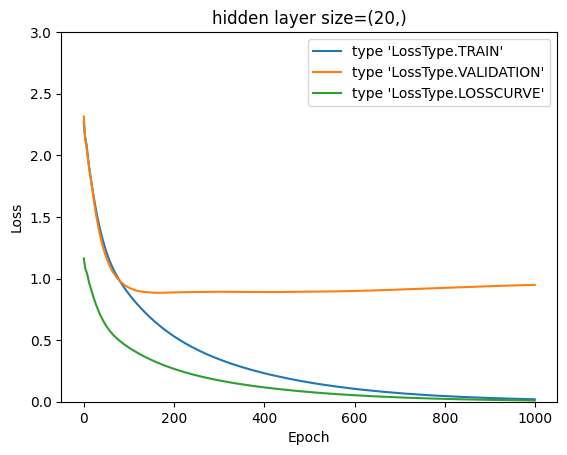

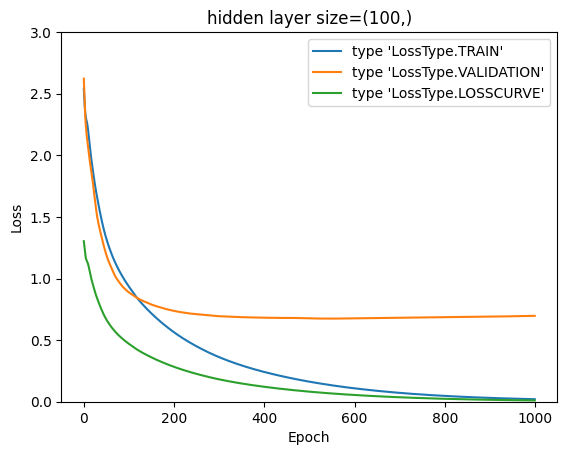

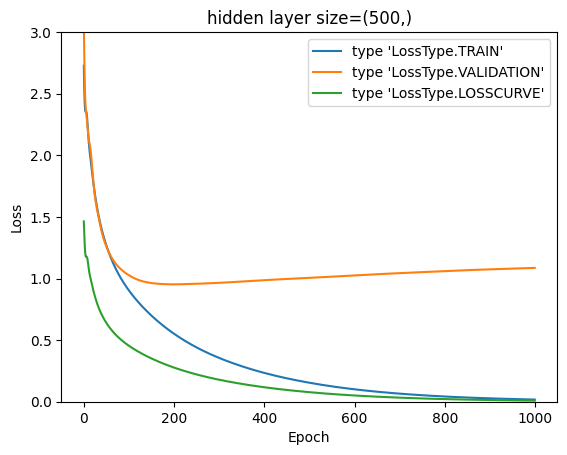

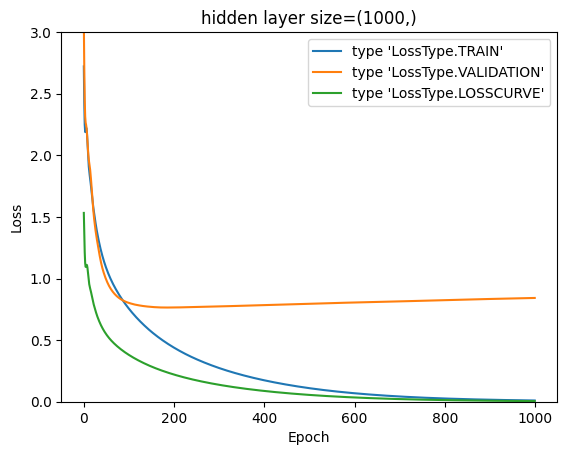

In [84]:
hidden_layer_sizes_testing()

In [88]:
def hidden_layer_sizes_testing_closer():
    hidden_layer_sizes = [(20,), (100,), (500,), (1000,)]
    loss_types = [LossType.TRAIN,LossType.VALIDATION,LossType.LOSSCURVE]
    for hls in hidden_layer_sizes:
        for lt in loss_types:
            train_loss =  run(hidden_sizes=hls,loss_type=lt)
            plt.plot(range(len(train_loss)), train_loss, label=f'type \'{str(lt)}\'')
        plt.title( f'hidden layer size={hls}')
        plt.ylim(0, 1)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

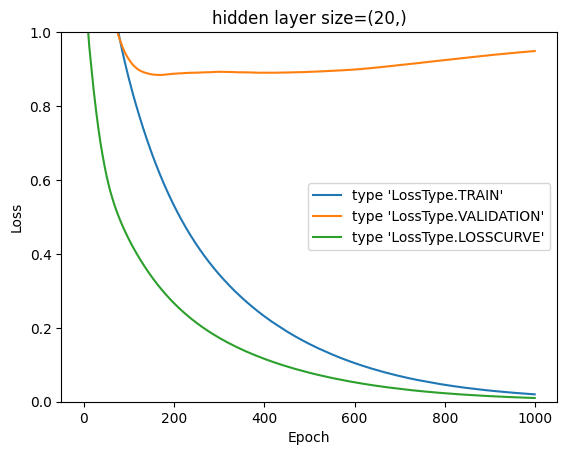

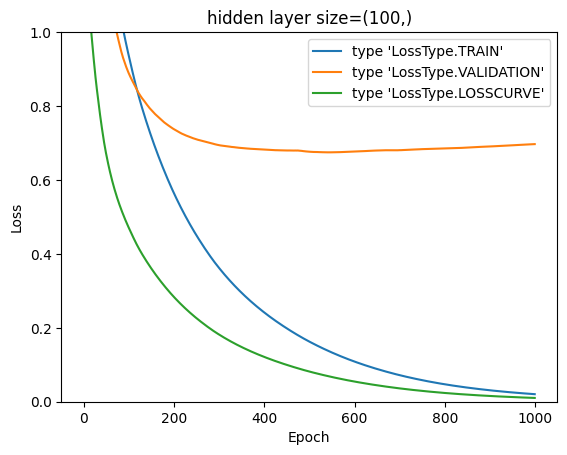

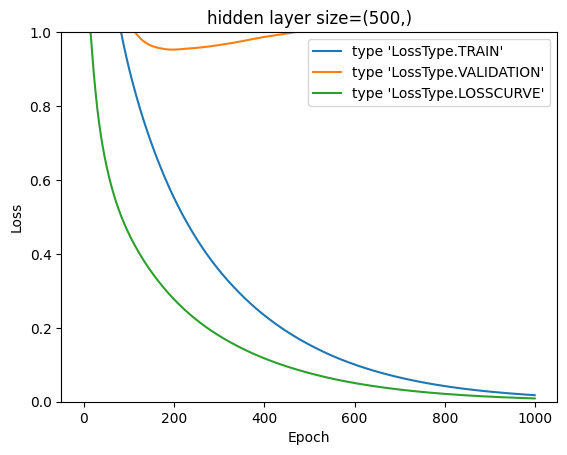

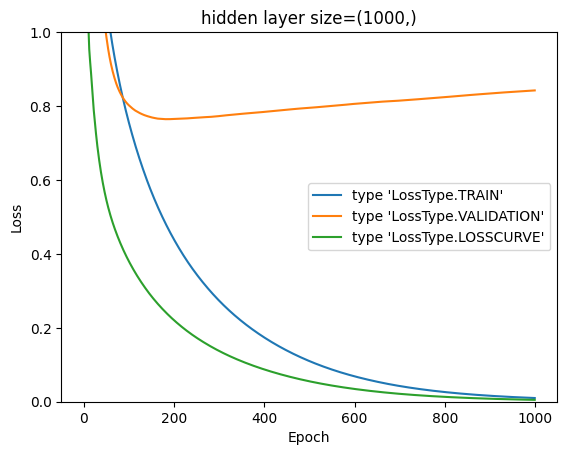

In [89]:
hidden_layer_sizes_testing_closer()

5. Wybierz najlepszy uzyskany w drodze powyższych eksperymentów model i przetestuj go w praktyce: znajdź (lub napisz własny) tekst o charakterze dowcipu, przetwórz go na wektor za pomocą używanej w zadaniach metody ekstrakcji cech, a następnie odpytaj model neuronowy. Czy predykcja zgadza się z Twoim oczekiwaniem? (15 punktów)

najlepsze rezultaty
hidden_layer_sizes = (100,)
hidden_rate = 0.001 'adaptive'
epochs = 1000


In [91]:
my_mlp = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='adaptive', learning_rate_init=0.001, hidden_layer_sizes=(100,), max_iter=1000, random_state=0)

my_mlp.fit(train_X, train_y)

MLPRegressor(alpha=0.0, learning_rate='adaptive', max_iter=1000, random_state=0,
             solver='sgd')

In [119]:
def how_funny_is_my_joke(joke):
    joke_embedding = model.encode([joke])
    joke_embedding = np.reshape(joke_embedding, (1, -1))
    rating_prediction = my_mlp.predict(joke_embedding)

    print("in [-10, 10] scale =", rating_prediction)


Najlepsze kawaly z podzialem na lata

From 2000:
Why don't scientists trust atoms? Because they make up everything!

From 2010:
Why don't skeletons fight each other? They don't have the guts!

From 2020:
Why did the scarecrow win an award? Because he was outstanding in his field!

From 2022:
Why don't scientists trust staircases? Because they're always up to something!

In [124]:
min(ratings),max(ratings)

(-3.7065558327315693, 3.560725588496214)

In [121]:
how_funny_is_my_joke("Why don't scientists trust atoms? Because they make up everything!")

in [-10, 10] scale = [-0.4128322]


In [122]:
how_funny_is_my_joke("Why don't skeletons fight each other? They don't have the guts!")

in [-10, 10] scale = [-0.08164401]


In [125]:
how_funny_is_my_joke("Why did the scarecrow win an award? Because he was outstanding in his field!")

in [-10, 10] scale = [-1.7289772]


In [126]:
how_funny_is_my_joke("Why don't scientists trust staircases? Because they're always up to something!")

in [-10, 10] scale = [-1.9068825]


From 1999-2003:

Why don't scientists trust atoms? Because they make up everything!
Why don't skeletons fight each other? They don't have the guts!
Why did the scarecrow win an award? Because he was outstanding in his field!
Why don't scientists trust staircases? Because they're always up to something!

In [127]:
how_funny_is_my_joke("Why don’t scientists trust atoms? Because they make up everything!")

in [-10, 10] scale = [-0.47630906]


In [129]:
how_funny_is_my_joke("Why did the scarecrow win an award? Because he was outstanding in his field!")

in [-10, 10] scale = [-1.7289772]


In [131]:
how_funny_is_my_joke("Why don't scientists trust stairs? Because they're always changing steps and trying to elevate their game!")

in [-10, 10] scale = [-0.29563951]


In [132]:
how_funny_is_my_joke("Why don't scientists trust atoms? Well, it all started with a group of scientists who were trying to understand the nature of matter. They were fascinated by atoms and their fundamental role in shaping the world around us. But as they delved deeper into their research, they started to notice something peculiar. Atoms seemed to have a mischievous side. Every time the scientists thought they had figured out the behavior of an atom, it would surprise them with new and unexpected properties. Atoms would bond and form molecules, create complex structures, and exhibit behaviors that seemed to defy conventional wisdom. The scientists realized that they couldn't fully trust atoms because they were constantly changing the rules. Just when they thought they had a grasp on how atoms worked, they would discover a new phenomenon that challenged their understanding. Despite the challenges, the scientists persevered. They continued to study atoms, unlock their secrets, and make groundbreaking discoveries. While they couldn't fully trust atoms, they couldn't deny their incredible power and influence in shaping the world we live in. so, the next time you hear someone say that scientists don't trust atoms, remember that it's not because they dislike them. It's because atoms are always keeping scientists on their toes, pushing the boundaries of knowledge and opening up new possibilities.")

in [-10, 10] scale = [1.2116008]
